In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
import tqdm
import datetime

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', 5000)

import plotly.io as pio
pio.templates.default = 'simple_white'
from bertopic import BERTopic

### Loading data

In [4]:
df = pd.read_csv('hotel_reviews_with_transl.csv', sep = '\t')

In [5]:
docs = list(df.reviews_transl)

### Building default model

In [34]:
%%time

topic_model = BERTopic()
topics, ini_probs = topic_model.fit_transform(docs)

CPU times: user 10min 49s, sys: 1min 19s, total: 12min 8s
Wall time: 3min 35s


In [35]:
num_topics = len(topic_model.get_topics()) - 1
num_topics

113

In [36]:
topic_model.get_topic_info().head(10).set_index('Topic')[['Count', 'Name', 'Representation']]

,Count,Name,Representation
Topic,,,
-1,6356,-1_the_and_to_was,"[the, and, to, was, in, of, for, we, room, it]"
0,315,0_london_great_location_hotel,"[london, great, location, hotel, stay, and, very, stayed, in, good]"
1,289,1_victoria_plaza_park_station,"[victoria, plaza, park, station, and, the, hotel, gatwick, we, to]"
2,228,2_paddington_heathrow_station_hilton,"[paddington, heathrow, station, hilton, express, the, to, is, and, in]"
3,201,3_gloucester_road_tube_is,"[gloucester, road, tube, is, the, and, millennium, hotel, location, room]"
4,190,4_radisson_edwardian_vanderbilt_hotel,"[radisson, edwardian, vanderbilt, hotel, the, and, in, very, london, to]"
5,159,5_was_the_had_to,"[was, the, had, to, room, not, shower, it, and, we]"
6,155,6_noise_noisy_the_sleep,"[noise, noisy, the, sleep, room, was, of, on, night, we]"
7,140,7_hilton_bridge_tower_london,"[hilton, bridge, tower, london, the, executive, and, is, of, in]"


In [37]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

In [38]:
topics_per_class = topic_model.topics_per_class(docs, classes=df.hotel)
fig = topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=10, 
                                      normalize_frequency = True)

fig.write_html('basic.html')
fig.show()

In [39]:
df['basic_topic'] = topics

In [40]:
# df[df.basic_topic == -1].sample(10)[['reviews_transl', 'reviews', 'course_id', 'rating']]

### Approximate topic distribution

In [41]:
def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare', 'Name', 'Representation'] + extra_cols]

In [42]:
# ! python -m spacy download en_core_web_sm

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance

main_representation_model = KeyBERTInspired()
aspect_representation_model1 = PartOfSpeech("en_core_web_sm")
aspect_representation_model2 = [KeyBERTInspired(top_n_words=30), MaximalMarginalRelevance(diversity=.5)]

representation_model = {
   "Main": main_representation_model,
   "Aspect1":  aspect_representation_model1,
   "Aspect2":  aspect_representation_model2 
}

vectorizer_model = CountVectorizer(min_df=5, stop_words = 'english')
topic_model = BERTopic(nr_topics = 'auto', vectorizer_model = vectorizer_model,
                      representation_model = representation_model)
topics, ini_probs = topic_model.fit_transform(docs)

In [44]:
num_topics = len(topic_model.get_topics()) - 1
num_topics

99

In [45]:
get_topic_stats(topic_model, ['Aspect1', 'Aspect2']).head(7).set_index('Topic')

,Count,Share,CumulativeShare,Name,Representation,Aspect1,Aspect2
Topic,,,,,,,
-1,6571,53.44,53.44,-1_hotels_hotel_rooms_room,"[hotels, hotel, rooms, room, london, inn, bathroom, bed, place, restaurant]","[room, hotel, good, breakfast, staff, stay, location, clean, night, rooms]","[hotels, room, london, place, restaurant, travelodge, shower, booked, bar, station]"
0,628,5.11,58.55,0_hotels_hotel_london_rooms,"[hotels, hotel, london, rooms, place, restaurant, restaurants, staying, room, city]","[hotel, great, stay, location, good, value, clean, breakfast, staff, nice]","[hotels, london, restaurants, room, travelodge, comfortable, station, shower, bus, bar]"
1,286,2.33,60.88,1_hotel_rooms_restaurant_restaurants,"[hotel, rooms, restaurant, restaurants, room, bathroom, beds, toiletries, meal, buffet]","[hotel, great, breakfast, staff, good, nice, stay, lovely, friendly, food]","[hotel, rooms, restaurants, beds, toiletries, coffee, evening, efficient, quality, stayed]"
2,280,2.28,63.16,2_london_victoria_hotel_hotels,"[london, victoria, hotel, hotels, buckingham, park, gatwick, palace, attractions, station]","[plaza, park, station, gatwick, great, hotel, location, modern, palace, train]","[hotels, buckingham, park, gatwick, palace, airport, bathroom, plaza, express, spacious]"
3,220,1.79,64.95,3_paddington_heathrow_london_hotel,"[paddington, heathrow, london, hotel, hotels, hilton, rooms, airport, bathroom, station]","[heathrow, station, hilton, express, train, hotel, great, room, location, airport]","[paddington, heathrow, hotels, airport, bathroom, lounge, express, metropole, starbucks, drinks]"
4,204,1.66,66.60,4_gloucester_hotels_hotel_london,"[gloucester, hotels, hotel, london, rooms, inn, pubs, nearby, place, restaurants]","[gloucester, road, tube, location, station, restaurants, great, hotel, millenium, room]","[gloucester, hotels, london, pubs, restaurants, kensington, room, shops, museum, concierge]"
5,192,1.56,68.17,5_radisson_radissons_edwardian_vanderbilt,"[radisson, radissons, edwardian, vanderbilt, hotel, hotels, raddison, rooms, room, museum]","[hotel, radissons, hotels, location, great, stay, staff, service, room, rooms]","[radisson, edwardian, vanderbilt, hotels, room, museum, bloomsbury, stayed, leicester, staff]"


In [46]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

In [47]:
df['basic_topic'] = topics

In [48]:
topic_model.visualize_topics()

### Finding similar topics

https://github.com/MaartenGr/BERTopic/issues/292

In [58]:
topic_model.visualize_heatmap(n_clusters = 20)

In [59]:
from sklearn.metrics.pairwise import cosine_similarity

In [60]:
distance_matrix = cosine_similarity(np.array(topic_model.topic_embeddings_))

In [61]:
dist_df = pd.DataFrame(distance_matrix, columns=topic_model.topic_labels_.values(), 
                       index=topic_model.topic_labels_.values())

In [62]:
tmp = []
for rec in dist_df.reset_index().to_dict('records'):
    t1 = rec['index']
    for t2 in rec:
        if t2 == 'index': 
            continue
        tmp.append(
            {
                'topic1': t1, 
                'topic2': t2, 
                'distance': rec[t2]
            }
        )

pair_dist_df = pd.DataFrame(tmp)

In [63]:
pair_dist_df = pair_dist_df[(pair_dist_df.topic1.map(lambda x: not x.startswith('-1'))) & 
            (pair_dist_df.topic2.map(lambda x: not x.startswith('-1')))]

In [64]:
pair_dist_df = pair_dist_df[pair_dist_df.topic1 < pair_dist_df.topic2]

In [68]:
pair_dist_df.sort_values('distance', ascending = False).head(30)

,topic1,topic2,distance
252,1_hotel_rooms_restaurant_restaurants,61_hotel_hostel_taxi_rooms,0.93
1107,10_worth_value_hotel_hotels,61_hotel_hostel_taxi_rooms,0.93
2739,27_mayfair_london_hotel_hotels,78_hotel_mayfair_hotels_rooms,0.93
216,1_hotel_rooms_restaurant_restaurants,25_hotels_hotel_nearby_bedroom,0.92
157,0_hotels_hotel_london_rooms,61_hotel_hostel_taxi_rooms,0.92
1180,11_hotel_hotels_noisy_noise,39_hotel_hotels_london_rooms,0.91
98,0_hotels_hotel_london_rooms,2_london_victoria_hotel_hotels,0.91
2212,22_thames_hotel_london_belfast,26_hotel_hotels_riverbank_riverview,0.91
118,0_hotels_hotel_london_rooms,22_thames_hotel_london_belfast,0.91
143,0_hotels_hotel_london_rooms,47_london_heathrow_hotel_brompton,0.91


In [66]:
def get_topic_representation(topic_model, topic):
    data = topic_model.get_topic(topic)
    
    return ', '.join(list(map(lambda x: x[0], data)))

df['merged_topic'] = topic_model.topics_
df['merged_topic_repr'] = df['merged_topic'].map(lambda x: get_topic_representation(topic_model, x))

In [67]:
df[df.merged_topic != df.basic_topic].shape[0], df.merged_topic.nunique()

(2970, 95)

In [69]:
topic_model.merge_topics(docs, [[27, 78], [47, 91], [38, 41]])

In [70]:
df['merged_topic'] = topic_model.topics_
df['merged_topic_repr'] = df['merged_topic'].map(lambda x: get_topic_representation(topic_model, x))

In [71]:
num_topics = len(topic_model.get_topics()) - 1
num_topics

91

In [72]:
get_topic_stats(topic_model).head(10)

,Topic,Count,Share,CumulativeShare,Name,Representation
0,-1,6571,53.44,53.44,-1_hotels_hotel_rooms_room,"[hotels, hotel, rooms, room, london, inn, bathroom, bed, place, restaurant]"
1,0,628,5.11,58.55,0_hotels_hotel_london_rooms,"[hotels, hotel, london, rooms, place, restaurant, restaurants, staying, room, city]"
2,1,286,2.33,60.88,1_hotel_rooms_restaurant_restaurants,"[hotel, rooms, restaurant, restaurants, room, bathroom, beds, place, meal, buffet]"
3,2,280,2.28,63.16,2_london_victoria_hotel_hotels,"[london, victoria, hotel, hotels, buckingham, park, gatwick, palace, attractions, station]"
4,3,220,1.79,64.95,3_paddington_heathrow_london_hotel,"[paddington, heathrow, london, hotel, hotels, hilton, rooms, airport, bathroom, station]"
5,4,204,1.66,66.60,4_gloucester_hotels_hotel_london,"[gloucester, hotels, hotel, london, rooms, inn, pubs, nearby, place, restaurants]"
6,5,192,1.56,68.17,5_radisson_radissons_edwardian_vanderbilt,"[radisson, radissons, edwardian, vanderbilt, hotel, hotels, raddison, rooms, room, museum]"
7,6,147,1.20,69.36,6_hotels_hotel_hilton_hiltons,"[hotels, hotel, hilton, hiltons, london, rooms, lounge, tower, restaurant, restaurants]"
8,7,139,1.13,70.49,7_rooms_hotel_room_bathroom,"[rooms, hotel, room, bathroom, carpet, curtains, bed, shower, smell, bath]"
9,8,131,1.07,71.56,8_hotel_hotels_oxford_rooms,"[hotel, hotels, oxford, rooms, st, restaurant, restaurants, booking, street, booked]"


In [73]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

In [74]:
topic_model.visualize_topics()

In [75]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, window = 4,
                                                                      calculate_tokens=True)

In [76]:
topic_distr.shape

(12295, 91)

Text(0.5, 1.0, 'Distribution of topic non-zero probabilities')

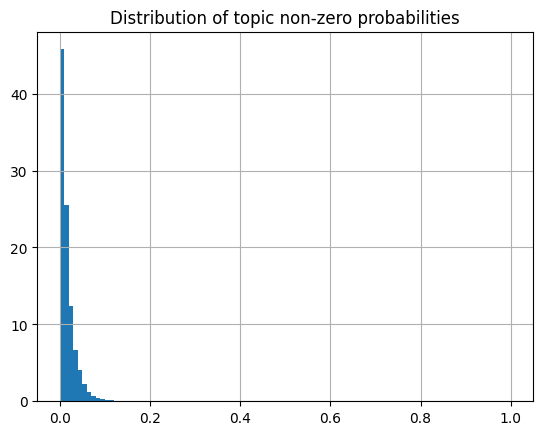

In [77]:
raw_distr = pd.Series(topic_distr.ravel())
raw_distr = raw_distr[raw_distr > 0]

ax = raw_distr.hist(bins = 100, range = [0, 1],
                                        weights = np.ones_like(raw_distr)*100/raw_distr.shape[0])
ax.set_title('Distribution of topic non-zero probabilities')

In [78]:
df['max_topic_distr'] = topic_distr.max(axis = 1)

In [81]:
1 - df[df.max_topic_distr > 0.05].shape[0]/df.shape[0]

0.057747051647010994

In [82]:
df = df.reset_index(drop=True)

In [92]:
# df[df.reviews_len < 200].sample(10)

In [93]:
# df[df.merged_topic == 3].sample(10)

In [121]:
df[(df.max_topic_distr > 0.1) & (df.reviews_len <= 100)].sample(10)

,id,hotel,review,lang,reviews_transl,reviews_len,basic_topic,merged_topic,merged_topic_repr,max_topic_distr
3278,3454,Holiday Inn,Heruntergekommenes Massenhotel mit uninteressiertem Personal.,de,Run down mass hotel with uninterested staff.,44,-1,-1,"hotels, hotel, rooms, room, london, inn, bathroom, bed, place, restaurant",0.12
2068,2183,Holiday Inn,Fantastic Value for $$$.,ca,Fantastic Value for $$$.,24,45,44,"value, money, price, discounted, good, excellent, better, reasonable, great, fantastic",0.34
2004,2116,Holiday Inn,ottimo albergo qualità prezzo e ubicazione.,it,excellent hotel quality price and location.,43,72,68,"hotels, hotel, marriott, hilton, budget, pleasant, worth, quality, value, cheap",0.36
6516,6847,Park Plaza,tres bon rapport qualite prix.,fr,Very good value for money.,26,45,44,"value, money, price, discounted, good, excellent, better, reasonable, great, fantastic",0.25
11945,12518,Holiday Inn,Cheap but bad location.,en,Cheap but bad location.,23,-1,-1,"hotels, hotel, rooms, room, london, inn, bathroom, bed, place, restaurant",0.36
9925,10393,Holiday Inn,An Above Average Experience.,en,An Above Average Experience.,28,60,57,"disappointment, disappointed, disappointing, surprised, pleasantly, surprise, terrible, expectations, expect, sad",0.50
5678,5950,Radisson,Loved the Radisson Edwardian.,en,Loved the Radisson Edwardian.,29,5,5,"radisson, radissons, edwardian, vanderbilt, hotel, hotels, raddison, rooms, room, museum",0.82
2385,2517,Radisson,superbe hotel classe et discrétion.,fr,superb hotel class and discretion.,34,14,15,"hotel, tourist, location, located, rooms, central, city, magnificent, splendid, pleasant",1.00
9103,9527,Millemiun,Great Location...Fine Hotel!.,en,Great Location...Fine Hotel!.,29,-1,-1,"hotels, hotel, rooms, room, london, inn, bathroom, bed, place, restaurant",0.16
1755,1858,Radisson,Sempre ottimo ma la ventilazione!!.,it,Always excellent but the ventilation!!.,39,-1,-1,"hotels, hotel, rooms, room, london, inn, bathroom, bed, place, restaurant",0.20


In [122]:
doc_id = 2116

In [123]:
topic_distr[3].max()

0.053283200082284016

In [130]:
topic_model.visualize_distribution(topic_distr[doc_id], min_probability=0.05)

In [126]:
# ! pip install pandas==1.5.3 # downgrade to fix issue https://github.com/dexplo/dataframe_image/issues/74

In [127]:
pd.__version__

'1.5.3'

In [128]:
# Visualize the token-level distributions
vis_df = topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])
vis_df

,london,its,best,very,beautiful,well,staffed,hotel,in,londons,most,unique,location,close,to,everything
0_hotels_hotel_london_rooms,0.143,0.143,0.143,0.143,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.102,0.102,0.102
2_london_victoria_hotel_hotels,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.101,0.101,0.101,0.101
6_hotels_hotel_hilton_hiltons,0.107,0.107,0.107,0.107,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8_hotel_hotels_oxford_rooms,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.123,0.123,0.123,0.123
15_hotel_tourist_location_located,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.154,0.154,0.154,0.154
23_hotel_decent_rooms_beds,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.127,0.127,0.127,0.127
27_hotels_hotel_nearby_bedroom,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.159,0.159,0.159,0.159
39_hotel_hotels_london_rooms,0.102,0.102,0.102,0.102,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
58_hotel_hotels_london_accommodation,0.216,0.216,0.216,0.216,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
71_london_vicinity_oxford_heathrow,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.179,0.179,0.179,0.179


In [135]:
tmp_dfs = []

for thr in tqdm.tqdm(np.arange(0, 0.15, 0.001)):
    tmp_df = pd.DataFrame(list(map(lambda x: len(list(filter(lambda y: y >= thr, x))), topic_distr))).rename(
        columns = {0: 'num_topics'}
    )
    tmp_df['num_docs'] = 1
    
    tmp_df['num_topics_group'] = tmp_df['num_topics']\
        .map(lambda x: str(x) if x < 5 else '5+')
    
    tmp_df_aggr = tmp_df.groupby('num_topics_group', as_index = False).num_docs.sum()
    tmp_df_aggr['threshold'] = thr
    
    tmp_dfs.append(tmp_df_aggr)

100%|█████████████████████████████████████████| 150/150 [00:10<00:00, 14.07it/s]


In [136]:
num_topics_stats_df = pd.concat(tmp_dfs).pivot(index = 'threshold', values = 'num_docs',
                              columns = 'num_topics_group').fillna(0)

In [137]:
num_topics_stats_df = num_topics_stats_df.apply(lambda x: 100.*x/num_topics_stats_df.sum(axis = 1))

In [138]:
colormap = px.colors.sequential.YlGnBu
px.area(num_topics_stats_df, 
       title = 'Distribution of number of topics',
       labels = {'num_topics_group': 'number of topics',
                'value': 'share of reviews, %'},
       color_discrete_map = {
          '0': colormap[0],
          '1': colormap[3],
          '2': colormap[4],
          '3': colormap[5],
          '4': colormap[6],
          '5+': colormap[7]
      })

### Processing multiple topics for docs

In [139]:
threshold = 0.05

In [140]:
df['multiple_topics'] = list(map(
    lambda doc_topic_distr: list(map(
        lambda y: y[0], filter(lambda x: x[1] >= threshold, 
                               (enumerate(doc_topic_distr)))
    )), topic_distr
))

In [142]:
tmp_data = []

for rec in df.to_dict('records'):
    if len(rec['multiple_topics']) != 0:
        mult_topics = rec['multiple_topics']
    else:
        mult_topics = [-1]
        
    for topic in mult_topics: 
        tmp_data.append(
            {
                'topic': topic,
                'id': rec['id'],
                'hotel': rec['hotel'],
                'reviews_transl': rec['reviews_transl']
            }
        )
        
        
mult_topics_df = pd.DataFrame(tmp_data)

In [145]:
tmp_data = []

for hotel in mult_topics_df.hotel.unique():
    for topic in mult_topics_df.topic.unique():
        tmp_data.append({
            'hotel': hotel,
            'topic_id': topic,
            'total_hotel_reviews': mult_topics_df[mult_topics_df.hotel == hotel].id.nunique(),
            'topic_hotel_reviews': mult_topics_df[(mult_topics_df.hotel == hotel) 
                                                  & (mult_topics_df.topic == topic)].id.nunique(),
            'other_hotels_reviews': mult_topics_df[mult_topics_df.hotel != hotel].id.nunique(),
            'topic_other_hotels_reviews': mult_topics_df[(mult_topics_df.hotel != hotel) 
                                                  & (mult_topics_df.topic == topic)].id.nunique()
        })
        
mult_topics_stats_df = pd.DataFrame(tmp_data)

In [146]:
mult_topics_stats_df['topic_hotel_share'] = 100*mult_topics_stats_df.topic_hotel_reviews/mult_topics_stats_df.total_hotel_reviews
mult_topics_stats_df['topic_other_hotels_share'] = 100*mult_topics_stats_df.topic_other_hotels_reviews/mult_topics_stats_df.other_hotels_reviews

In [147]:
from statsmodels.stats.proportion import proportions_ztest

In [148]:
mult_topics_stats_df['difference_pval'] = list(map(
    lambda x1, x2, n1, n2: proportions_ztest(
        count = [x1, x2],
        nobs = [n1, n2],
        alternative = 'two-sided'
    )[1],
    mult_topics_stats_df.topic_other_hotels_reviews,
    mult_topics_stats_df.topic_hotel_reviews,
    mult_topics_stats_df.other_hotels_reviews,
    mult_topics_stats_df.total_hotel_reviews
))

In [149]:
mult_topics_stats_df['sign_difference'] = mult_topics_stats_df.difference_pval.map(
    lambda x: 1 if x <= 0.05 else 0
)

def relative_actuality(d, sign):
    sign_percent = 1
    if sign == 0:
        return 'no diff'
    if (d >= -sign_percent) and (d <= sign_percent):
        return 'no diff'
    if d < -sign_percent:
        return 'lower'
    if d > sign_percent:
        return 'higher'
    
mult_topics_stats_df['diff_significance_total'] = list(map(
    relative_actuality,
    mult_topics_stats_df.topic_hotel_share - mult_topics_stats_df.topic_other_hotels_share,
    mult_topics_stats_df.sign_difference
))

In [155]:
import plotly
def get_color_sign(rel):
    if rel == 'no diff':
        return plotly.colors.qualitative.Set2[7]
    if rel == 'lower':
        return plotly.colors.qualitative.Set2[1]
    if rel == 'higher':
        return plotly.colors.qualitative.Set2[0]
    
def get_topic_representation_title(topic_model, topic):
    data = topic_model.get_topic(topic)
    data = list(map(lambda x: x[0], data))
    
    return ', '.join(data[:5]) + ', <br>         ' + ', '.join(data[5:])

def get_graphs_for_topic(t):
    topic_stats_df = mult_topics_stats_df[mult_topics_stats_df.topic_id == t]\
        .sort_values('total_hotel_reviews', ascending = False).set_index('hotel')
    

    colors = list(map(
        get_color_sign,
        topic_stats_df.diff_significance_total
    ))
    
    
    fig = px.bar(topic_stats_df.reset_index(), x = 'hotel', y = 'topic_hotel_share',
                title = 'Topic: %s' % get_topic_representation_title(topic_model, 
                                                            topic_stats_df.topic_id.min()),
                text_auto = '.1f',
                labels = {'topic_hotel_share': 'share of reviews, %'},
                hover_data=['topic_id'])
    fig.update_layout(showlegend = False)
    fig.update_traces(marker_color=colors, marker_line_color=colors,
                  marker_line_width=1.5, opacity=0.9)
    
    
    topic_total_share = 100.*((topic_stats_df.topic_hotel_reviews + topic_stats_df.topic_other_hotels_reviews)\
        /(topic_stats_df.total_hotel_reviews + topic_stats_df.other_hotels_reviews)).min()
    print(topic_total_share)
    
    fig.add_shape(type="line",
        xref="paper",
        x0=0, y0=topic_total_share,
        x1=1, y1=topic_total_share,
        line=dict(
            color=colormap[8],
            width=3, dash="dot"
        )
    )
    
    fig.show()

In [156]:
top_mult_topics_df = mult_topics_df.groupby('topic', as_index = False).id.nunique()

In [157]:
top_mult_topics_df['share'] = 100.*top_mult_topics_df.id/top_mult_topics_df.id.sum()
top_mult_topics_df['topic_repr'] = top_mult_topics_df.topic.map(
    lambda x: get_topic_representation(topic_model, x)
)

In [158]:
top_mult_topics_df = top_mult_topics_df.sort_values('id', ascending = False)
top_mult_topics_df.head(15)

,topic,id,share,topic_repr
16,15,3878,9.90,"hotel, tourist, location, located, rooms, central, city, magnificent, splendid, pleasant"
1,0,2847,7.27,"hotels, hotel, london, rooms, place, restaurant, restaurants, staying, room, city"
28,27,2538,6.48,"hotels, hotel, nearby, bedroom, place, rooms, attractions, location, restaurant, places"
2,1,2503,6.39,"hotel, rooms, restaurant, restaurants, room, bathroom, beds, place, meal, buffet"
91,90,1490,3.80,"location, priced, price, value, reasonably, great, excellent, reasonable, good, stopover"
65,64,1416,3.61,"hotel, london, covent, restaurant, attractions, restaurants, welcoming, oxford, friendly, regent"
59,58,1412,3.60,"hotel, hotels, london, accommodation, londontown, thames, visiting, travellers, uk, central"
88,87,1218,3.11,"stayed, stay, place, location, away, great, loved, excellent, happy, definitely"
69,68,1203,3.07,"hotels, hotel, marriott, hilton, budget, pleasant, worth, quality, value, cheap"
11,10,1101,2.81,"worth, value, hotel, hotels, rooms, price, rate, reviews, money, reception"


In [160]:
for t in top_mult_topics_df.head(32).topic.values:
    get_graphs_for_topic(t)

31.54127694184628


23.15575437169581


20.642537616917448


20.35786905246035


12.118747458316388


11.516876779178528


11.48434322895486


9.906466043106954


9.784465229768198


8.95485969906466


8.222854819032127


6.400976006506711


5.774705164701098


5.555103700691338


5.302968686457909


5.189101260675071


5.08336722244815


4.58723058153721


3.960959739731598


3.7820252135014236


3.3509556730378205


3.3428222854819034


3.294021960146401


3.2045546970313135


3.098820658804392


3.090687271248475


3.0418869459129727


2.7897519316795445


2.643350955673038


2.5376169174461163


2.448149654331029


2.4400162667751117


In [168]:
mult_topics_df[(mult_topics_df.topic == 65) & (mult_topics_df.reviews_transl.map(lambda x: 'refurb' in x))].sample(10)

,topic,id,hotel,reviews_transl
20216,65,6675,Park Plaza,"Good middle class hotel. The hotel is ideally situated near Bakerstreet underground station, servicing four lines (Jubilee, Circle, Bakerloo and Hamersmith &amp; City). The balance between price and quality is ok. We arrived early in the morning and we could check in immediately. Don't expect much from the executive room but I expect it's a little more spacious than a deluxe room. The bathroom was small but the shower (in the bath tub) was ok. No more Molton Brown amenities, but they provide you with large big towels. Refresing of the room takes also place in the early evening, that's nice! Our room had a window that could be opened so we slept in a fresh room. We didn't hear any noise, because we slept at the back of the hotel. The beds are good, rather soft matrasses but I like to sleep in a soft bed. However, the carpet and the furniture could have a refurbishment.Breakfast was in buffet style. Not very extended but they have scrambled eggs now. Also sausages, different choises of froot, fresh bread, croissants etc. In the basement there is a gym and a sauna / steam bath, not too big, but nice if you spend your day in the busy city. Staff is not always very professional (not as in 5 star hotels), but nevertheless, they are friendly.Overall, I think the hotel is ok, especially because of it's central location."
25359,65,8337,Hilton,Great refurbishment Fabulous Staff.
22228,65,7333,Radisson,"Beautifully and completely remodeled modern ideally located.. This is a very, very nice property that appears to be completely refurbished (not simply remodeled!) Our room was really perfect for our needs. The bathrooms, with their rain-style shower heads and marble or granite construction was definately a highlight. The British Museum is less than a block away. There is a small convenience store across the street. There is a bus stop 1/2 block away and the Tottenham Court Road subway station is about 2 blocks away. There are theaters within walking distance, a major YMCA health club, many restaurants, shopping, and other retail stores. The St. Pancras international rail station is nearby. If you are in London for business or pleasure, you really can't go wrong by staying here."
8119,65,2676,Hilton,Must have been lucky . . .. . . .and landed a refurbed room. Everything just fine. Great value for a weekend break. And what a view (see picture). Food &amp; staff both top rate!
34059,65,11210,Hilton,"it has its ups and downs. stayed at this hilton property for 6 nights. staff was corteous but not very responsive. plus: location. it's built right over queensway station. beware that this tube stop will be closed for refurbishings for one year! so you might consider noise levels. it's opposite hyde park and convenient to shopping, eating (although quite expensive) and public transport. the room was spacious, but didn't have a/c. i would rate cleanliness a 5 stars!minuses: although i am a smoker couldn't open the windows for fresh air. no ice machines available and the staff, sometimes very friendly and sometimes...... not.but for the price i payed (£99) i still consider this one of the best bargains you can get in london. beware of staying there in the hot months though!"
31713,65,10433,Holiday Inn,"What an improvement. I stayed in this hotel last year for a conference a visit each year. I like Holiday Inn Express as a brand and so choose to return to this hotel in the City. What an improvement a year makes! The place looks fantastic - light and welcoming, it's reception and ground floor areas have all been refurbished and it shows. This reflects in the staff who where happy and helpful. Will be returning!"
13807,65,4575,Park Inn,"Building works a problem.... Stayed for one night during recent business trip.Room really tired and awaiting renovation. Bed most uncomfortable with wafer thin pillows. Hot breakfast quite unremarkable low grade produce, syrup based watery juices etc.Building wor

In [164]:
# top_mult_topics_df.head(50)